In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer
import emoji
import random

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'

In [3]:
with open("../data/id2label.pickle", "rb+") as f:
    id2label = pickle.load(f)

In [4]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Plotting Curves

In [5]:
train_accs = np.load('../model0530/train_accs.npy')
train_losses = np.load('../model0530/train_losses.npy')
eval_accs = np.load('../model0530/eval_accs.npy')
eval_losses = np.load('../model0530/eval_losses.npy')

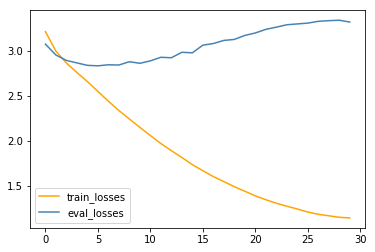

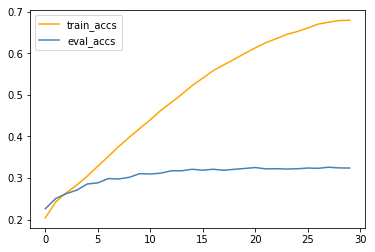

In [6]:
plt.plot(range(30), train_losses, color='orange', label='train_losses')
plt.plot(range(30), eval_losses, color='steelblue', label='eval_losses')
plt.legend()
plt.show()

plt.plot(range(30), train_accs, color='orange', label='train_accs')
plt.plot(range(30), eval_accs, color='steelblue', label='eval_accs')
plt.legend()
plt.show()

In [7]:
best_eval_acc = eval_accs.max()
best_eval_acc

0.3259837732937408

### Load Model

In [8]:
model = torch.load('../model0530/bertclassifier_epoch_27',  
                   map_location=lambda storage, loc: storage)
model.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

### Evaluate model with Top-5

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

In [10]:
sents = np.load('../data/test_tiny_sentences.npy')
labels = np.load('../data/test_tiny_labels.npy')

Evaluating...
1000 / 42769
2000 / 42769
3000 / 42769
4000 / 42769
5000 / 42769
6000 / 42769
7000 / 42769
8000 / 42769
9000 / 42769
10000 / 42769
11000 / 42769
12000 / 42769
13000 / 42769
14000 / 42769
15000 / 42769
16000 / 42769
17000 / 42769
18000 / 42769
19000 / 42769
20000 / 42769
21000 / 42769
22000 / 42769
23000 / 42769
24000 / 42769
25000 / 42769
26000 / 42769
27000 / 42769
28000 / 42769
29000 / 42769
30000 / 42769
31000 / 42769
32000 / 42769
33000 / 42769
34000 / 42769
35000 / 42769
36000 / 42769
37000 / 42769
38000 / 42769
39000 / 42769
40000 / 42769
41000 / 42769
42000 / 42769
Top5 Acc: 0.526643
             precision    recall  f1-score   support

          0       0.29      0.27      0.28      3252
          1       0.27      0.07      0.11       519
          2       0.25      0.38      0.30      1069
          3       0.50      0.47      0.48      7809
          4       0.09      0.07      0.08       384
          5       0.25      0.45      0.32       567
          6     

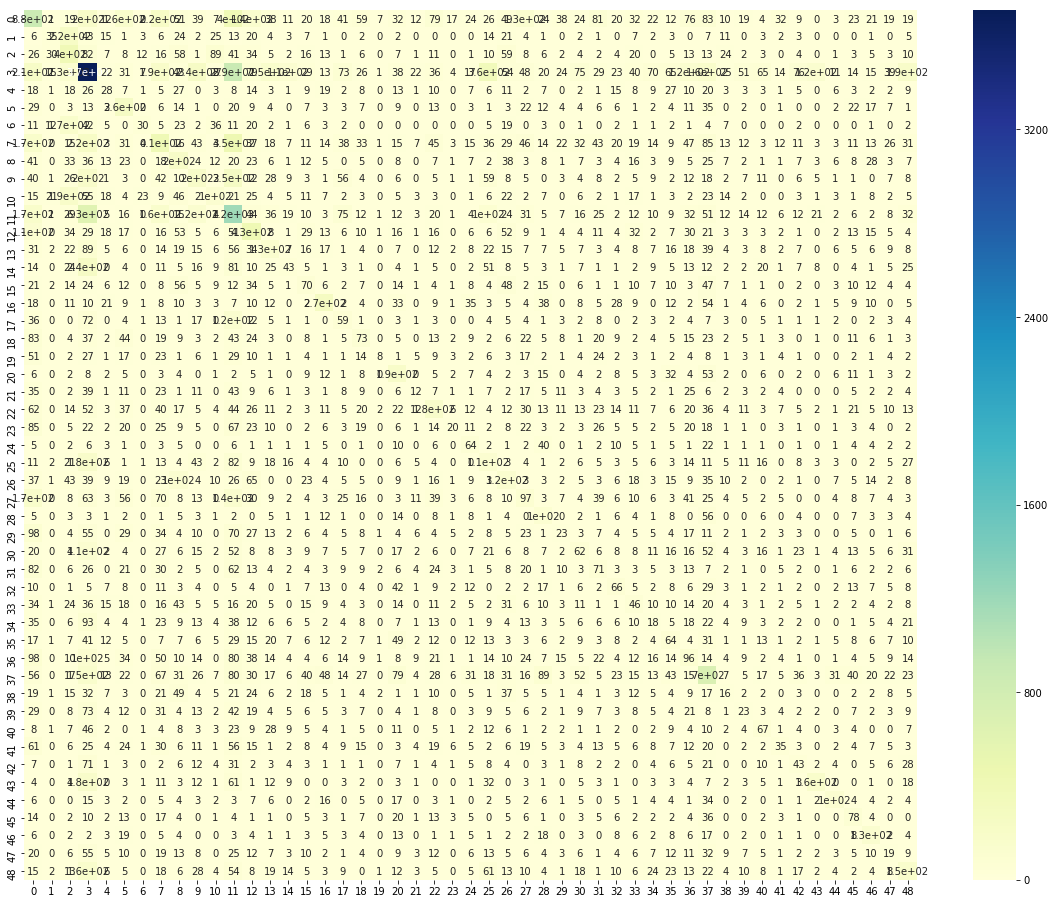

In [11]:
def eval(model, sents, labels, print_every=1000):
    print("Evaluating...")
    model.eval()
    
    n = sents.shape[0]
    # n = 1000
    y_real, y_pred = [], []
    top5_correct = 0
    
    for idx in range(n):
        if (idx+1) % print_every == 0:
            print("{} / {}".format(idx+1, n))
        sent, label = sents[idx], labels[idx]
        random_label = random.choice(label)
        tokens_tensor = torch.tensor([sent])
        with torch.no_grad():
            outputs = model(tokens_tensor)
            
        probs = torch.nn.functional.softmax(outputs, dim=-1).numpy().squeeze()
        top1 = probs.argmax()
        top5 = np.argpartition(-probs, kth=5)[:5]
        # print(top1, top5, random_label)
        y_pred.append(top1)
        y_real.append(random_label)
        if random_label in top5:
            top5_correct += 1
            
    print("Top5 Acc: {:.6f}".format(top5_correct/n))
    print(classification_report(y_real, y_pred))
    cm = confusion_matrix(y_real, y_pred)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize = (20, 16))
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
    
    return df_cm
    
df_cm = eval(model, sents, labels)

### Test on novel texts

In [12]:
def emojize_novel_text(text):
    tokenized_text = bert_tokenizer.tokenize(text)
    indexed_tokens = bert_tokenizer.convert_tokens_to_ids(tokenized_text)
    print(tokenized_text, indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    # tokens_tensor = tokens_tensor.to('cuda')
    # print(tokens_tensor)

    with torch.no_grad():
        outputs = model(tokens_tensor)

    probs = torch.nn.functional.softmax(outputs, dim=-1).numpy().squeeze()
    # print(probs)
    for idx in np.argpartition(-probs, kth=5)[:5]:
        print(emoji.emojize(id2label[idx]))

In [13]:
emojize_novel_text('I love deep learning')

['i', 'love', 'deep', 'learning'] [1045, 2293, 2784, 4083]
🔥
😍
❤
😂
😭


In [14]:
emojize_novel_text('But I hate doing homework')

['but', 'i', 'hate', 'doing', 'homework'] [2021, 1045, 5223, 2725, 19453]
😂
😭
🙄
💀
😩


In [15]:
# from valid.txt
emojize_novel_text('I would marry her on the spot') #:face_with_tears_of_joy:
emojize_novel_text('nobody can say beyonce cant sing') #:smiling_face_with_heart-eyes:
emojize_novel_text_text('60 Russians expelled from the US Now if we could just get the ONE out of the White House') #:double_exclamation_mark:

['i', 'would', 'marry', 'her', 'on', 'the', 'spot'] [1045, 2052, 5914, 2014, 2006, 1996, 3962]
:beaming_face_with_smiling_eyes:
😊
😉
😂
❤
['nobody', 'can', 'say', 'beyonce', 'can', '##t', 'sing'] [6343, 2064, 2360, 20773, 2064, 2102, 6170]
😩
😭
🔥
😂
😍
['60', 'russians', 'expelled', 'from', 'the', 'us', 'now', 'if', 'we', 'could', 'just', 'get', 'the', 'one', 'out', 'of', 'the', 'white', 'house'] [3438, 12513, 10016, 2013, 1996, 2149, 2085, 2065, 2057, 2071, 2074, 2131, 1996, 2028, 2041, 1997, 1996, 2317, 2160]
👇
🚨
💥
‼
🔥
